<a href="https://colab.research.google.com/github/prashanthi411/eng-hin-nlp/blob/master/RathiKashi_PrashanthiR_Eng_Hin_tensorflow_nmt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os 
import io
import time
!pip3 install indic-nlp-library

# Downloading the English-hindi dataset

The dataset consists of four files: two train files and two test files. The train file consists of one file with English sentences and another with the corresponding Hindi translations, similarly for the test files. 

The train files contain 84557 translations, out of which we will be using 70,000 for training. The test files contain 1000 translations.

In [0]:
!wget "http://lotus.kuee.kyoto-u.ac.jp/WAT/indic-multilingual/indic_languages_corpus.tar.gz"

--2020-05-06 08:42:40--  http://lotus.kuee.kyoto-u.ac.jp/WAT/indic-multilingual/indic_languages_corpus.tar.gz
Resolving lotus.kuee.kyoto-u.ac.jp (lotus.kuee.kyoto-u.ac.jp)... 130.54.208.131
Connecting to lotus.kuee.kyoto-u.ac.jp (lotus.kuee.kyoto-u.ac.jp)|130.54.208.131|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132762852 (127M) [application/x-gzip]
Saving to: ‘indic_languages_corpus.tar.gz.1’

indic_languages_cor 100%[===================>] 126.61M  25.4MB/s    in 12s     

2020-05-06 08:42:53 (10.5 MB/s) - ‘indic_languages_corpus.tar.gz.1’ saved [132762852/132762852]



In [0]:
import tarfile
with tarfile.open('indic_languages_corpus.tar.gz', 'r:gz') as tar:
    tar.extractall()
print("done!")

done!


In [0]:
%cd indic_languages_corpus/bilingual/hi-en/

/content/indic_languages_corpus/bilingual/hi-en


In [0]:
# set the batch size to 64. restricting the total number of sentences to 70000
BATCH_SIZE = 64
NUM_SENTENCES = 70000

In [0]:
# understanding how the training data looks like
f = open('train.hi')
w1 = f.readlines()
print(len(w1))
g = open('train.en')
w2 = g.readlines()

84557


# Preprocessing Data

Once we have loaded the dataset, we preprocess the data as follows:

1. Add a start and end token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [0]:
# strip the input and output of extra unnecessary characters
# store all the cleaned input and output sentences into input_sentences[] and output_sentences[]
# tokenize the Hindi (target) sentences using the indicNLP libary class and add <sos> (start-of-sentence) and <eos> (end-of-sentence)

input_sentences = []
output_sentences = []

count = 0
for line in open(r'train.en', encoding="utf-8"):
    count += 1

    if count > NUM_SENTENCES:
        break

    input_sentence = line.rstrip().strip("\n").strip('-') #we strip the sentence of '\n' and '-' 
    input_sentences.append(input_sentence) #store all input sentences in the input sentences list

count = 0

for line in open(r'train.hi'):
    count += 1

    if count > NUM_SENTENCES:
        break
    output_sentence =  line.rstrip().strip("\n").strip('-') 
    from indicnlp.tokenize import indic_tokenize  
    line = indic_tokenize.trivial_tokenize(output_sentence) #we tokenize the hindi sentences 
    
    output_sentences.append(['<sos>'] + line + ['<eos>']) #append the start and end tags to the tokenised sentences
                                                          #each tokenied sentence is stored as a list in output sentences
print(type(input_sentences[10]))
print(type(output_sentences[10]))

<class 'str'>
<class 'list'>


In [0]:
print("num samples input:", len(input_sentences))
print("num samples output:", len(output_sentences))

num samples input: 70000
num samples output: 70000


In [0]:
print(input_sentences[-1])
print(output_sentences[-1])

Her face.
['<sos>', 'उसका', 'चेहरा', '.', '<eos>']


In [0]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."

  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<sos> ' + w + ' <eos>'
  return w

In [0]:
for i in range(len(input_sentences)):
   input_sentences[i] = preprocess_sentence(input_sentences[i])

print(input_sentences[8])
print(output_sentences[8])

<sos> i told her we rest on sundays . <eos>
['<sos>', 'मैं', 'रविवार', 'को', 'उसे', 'हम', 'बाकी', 'बताया', '.', '<eos>']


In [0]:
# function to tokenize, fit the words into numeric sequences and pad them with zeroes up to the size of the largest sentence of that vocabulary
# takes as input the input / output vocabulary and the padding type ('pre' / 'post'-- default: post)

# inp_lang and targ_lang is of type tokenizer.fit_on_texts; 
# fit_on_texts of Tokenizer class updates internal vocabulary based on a list of texts. 
# This method creates the vocabulary index based on word frequency. 
# Lower integer means more frequent word (often the first few are stop words because they appear a lot).

def tokenize(lang, pad): 
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')

  lang_tokenizer.fit_on_texts(lang)
  
  tensor = lang_tokenizer.texts_to_sequences(lang)
  
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
  return tensor, lang_tokenizer

In [0]:
# function to call the tokenize function to perform tokenizing and padding

def load_dataset(inp_lang, targ_lang):
  # creating cleaned input, output pairs
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang, 'post')
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang, 'post')

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [0]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(input_sentences, output_sentences)

# Calculate max_length of the target tensors
# For our project, the max_length_targ and max_length_inp are 69 and 72 respectively.

max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [0]:
# checking if the input sequences have been obtained and padded properly
print(target_tensor[9])
print(input_tensor[9])

[  1  47 203  18 203  26  39 553  79  29   5 270   8   2   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[   1    5  106   62   63  462 6235   21    4   59    8    2    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [0]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

56000 56000 14000 14000


In [0]:
# checking if the input sequences have been obtained and padded properly
print(input_tensor_val[9])
print(target_tensor_val[9])

[  1   6  34  27 120 277   3   2   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[  1   9  37  61 188  32   3   2   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [0]:
# a function to test if the word to index / index to word mappings have been obtained correctly. 
# representative output for two sample english and hindi sentences given in the code block below

def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [0]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <sos>
138 ----> yes
4 ----> ,
6 ----> i
486 ----> promise
3 ----> .
2 ----> <eos>

Target Language; index to word mapping
1 ----> <sos>
362 ----> हां
5 ----> ,
9 ----> मैं
367 ----> वादा
121 ----> करता
32 ----> हूँ
3 ----> .
2 ----> <eos>


# Creating a tf dataset

In [0]:
# BUFFER_SIZE stores the number of training points
BUFFER_SIZE = len(input_tensor_train)

# BATCH_SIZE is set to 64. Training and gradient descent happens in batches of 64
BATCH_SIZE = 64

# the number of batches in one epoch (also, the number of steps during training, when we go batch by batch)
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE

# the length of the embedded vector
embedding_dim = 256

# no of GRUs
units = 1024 

# getting the size of the input and output vocabularies.
vocab_inp_size = len(inp_lang.word_index)+1 
vocab_tar_size = len(targ_lang.word_index)+1

# now, we shuffle the dataset and split it into batches of 64
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # the remainder after splitting by 64 are dropped

print(BUFFER_SIZE)
print(BUFFER_SIZE//64)
print(steps_per_epoch)

56000
875
875


In [0]:
# to understand the shape of an input batch
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 72]), TensorShape([64, 69]))

# **Encoder-Decoder model with attention**

The encoder model consists of an embedding layer, a GRU layer with 1024 units.

The decoder model consists of an attention layer, a embedding layer, a GRU layer and a dense layer.

The attention model consists of three dense layers.

The model is as follows (with GRUs instead of LSTMs):


<img src="https://i.ytimg.com/vi/p3jmVkUMMuw/maxresdefault.jpg" width="500" alt="attention mechanism">

We gratefully acknowledge the [tensorflow tutorial](https://tensorflow.org/tutorials/text/nmt_with_attention) and the  [stackabuse tutorial](https://stackabuse.com/python-for-nlp-neural-machine-translation-with-seq2seq-in-keras/) for the creation of these networks.


In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz # set batch size
    self.enc_units = enc_units # set the number of GRU units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) # set the embedding layer using the input's vocabulary size and the embedding dimension (which is set to 256)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform') # define the GRU layer

  def call(self, x, hidden): # this function is invoked when the function encoder is called with an input and an initialised hidden layer
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden) # pass input x into the GRU layer
    return output, state # function returns the encoder output and the hidden state


  def initialize_hidden_state(self): #intialise hidden layer to all zeroes (for determining the shape)
    return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE) # create an Encoder class object

# sample input to get a sense of the shapes.
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 72, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [0]:
# a class defined for the attention layer
# returns attention weights and context vector.

class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units) # fully-connected dense layer-1
    self.W2 = tf.keras.layers.Dense(units) # fully-connected dense layer-2
    self.V = tf.keras.layers.Dense(1) # fully-connected dense layer-3

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
attention_layer = BahdanauAttention(10) # create an attention layer object
attention_result, attention_weights = attention_layer(sample_hidden, sample_output) # pass sample encoder output and hidden layer to get a sense of the shape of the output of the attention layer.

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 72, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz # batch_size which is defined as 64
    self.dec_units = dec_units # the number of decoder GRU units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) # defining an embedding layer for the target language output. 
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform') # GRU layer
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output) # getting the context vector and the attention weights from the attention layer

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x) # creating an embedding layer for the target output

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output) # pass the output through the dense layer

    return x, state, attention_weights # return decoder output, decoder state and attention weights

In [0]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 22224)


# Defining the loss function

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') #Loss function is categorical crossentropy

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# Training the model

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<sos>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables) 

  optimizer.apply_gradients(zip(gradients, variables)) # doing gradient descent

  return batch_loss

In [0]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.3010
Epoch 1 Batch 100 Loss 0.8172
Epoch 1 Batch 200 Loss 0.8098
Epoch 1 Batch 300 Loss 0.7426
Epoch 1 Batch 400 Loss 0.6993
Epoch 1 Batch 500 Loss 0.7266
Epoch 1 Batch 600 Loss 0.5776
Epoch 1 Batch 700 Loss 0.5846
Epoch 1 Batch 800 Loss 0.7301
Epoch 1 Loss 0.7040
Time taken for 1 epoch 699.3439862728119 sec

Epoch 2 Batch 0 Loss 0.5775
Epoch 2 Batch 100 Loss 0.6035
Epoch 2 Batch 200 Loss 0.5631
Epoch 2 Batch 300 Loss 0.5489
Epoch 2 Batch 400 Loss 0.5983
Epoch 2 Batch 500 Loss 0.5768
Epoch 2 Batch 600 Loss 0.5607
Epoch 2 Batch 700 Loss 0.6239
Epoch 2 Batch 800 Loss 0.5970
Epoch 2 Loss 0.5525
Time taken for 1 epoch 632.6380219459534 sec

Epoch 3 Batch 0 Loss 0.4759
Epoch 3 Batch 100 Loss 0.4573
Epoch 3 Batch 200 Loss 0.4785
Epoch 3 Batch 300 Loss 0.4126
Epoch 3 Batch 400 Loss 0.4152
Epoch 3 Batch 500 Loss 0.5087
Epoch 3 Batch 600 Loss 0.4288
Epoch 3 Batch 700 Loss 0.4258
Epoch 3 Batch 800 Loss 0.3912
Epoch 3 Loss 0.4546
Time taken for 1 epoch 631.2751507759094 sec

# Prediction Model

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<sos>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
    
    # pass the encoder output, decoder hidden state(which is initialised to encoder hidden state for the first time and decoder input to the decoder)
    # make a prediction and obtain decoder hidden states and attention weights

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<eos>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

NOTE: In order to plot the attention weights upload the Lohit-Devanagari.ttf file onto the /content section of colab. (The ttf file is part of the folder of this submission).

In [0]:
% cd 
% cd/content
% ls

/root
/content
indic_languages_corpus/        Lohit-Devanagari.ttf
indic_languages_corpus.tar.gz  sample_data/


In [0]:
# function for plotting the attention weights
from matplotlib.font_manager import FontProperties

def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 18}
  hindi_font = FontProperties(fname = 'Lohit-Devanagari.ttf')

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontproperties=hindi_font, fontsize='18')
  # ax.set_yticklabels([''] + predicted_sentence, fontname='Lohit Devanagari')

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  
  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))
  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

  return result

In [0]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Testing the model

Input: <sos> i am hungry <eos>
Predicted translation: मुझे भूख लगी है <eos> 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 101 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 111 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 115 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 101 missing from current font.
  font.set_text(s, 0, f

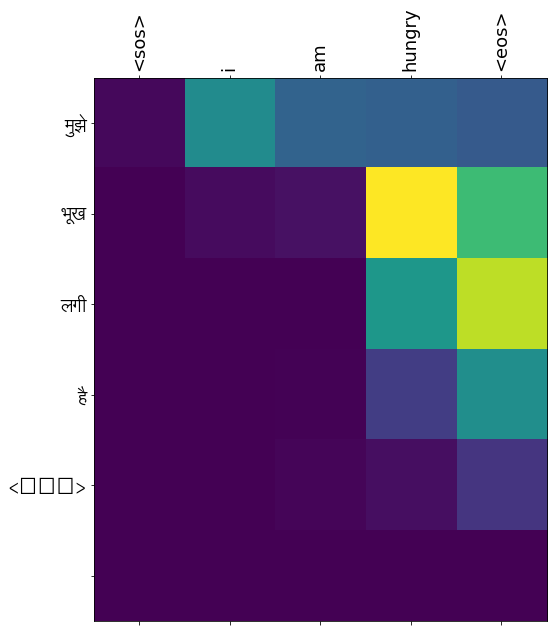

मुझे भूख लगी है <eos> 


In [0]:
print(translate("I am hungry"))

# Pre processing test data

In [0]:
test_input_sentences = []
test_output_sentences = []

for line in open(r'test.en', encoding="utf-8"):

    test_input_sentence = line.rstrip().strip("\n").strip('-')
    test_input_sentences.append(test_input_sentence)


for line in open(r'test.hi'):
    test_output_sentence =  line.rstrip().strip("\n").strip('-')
    line = indic_tokenize.trivial_tokenize(test_output_sentence)
    
    test_output_sentences.append(['<sos>'] + line + ['<eos>'])
    
print(type(test_input_sentences[90]))
print(len(test_output_sentences))
print(test_input_sentences[90])
print(test_output_sentences[90])

<class 'str'>
1000
You're slower than molasses in January.
['<sos>', 'आप', 'जनवरी', 'में', 'गुड़', 'की', 'तुलना', 'में', 'धीमी', 'है', '.', '<eos>']


# Calculating BLEU score

In [0]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
chencherry = SmoothingFunction()

references = []
candidates = []
for i in range(len(test_input_sentences)):
  try:
    res = translate(test_input_sentences[i]) 
    references.append(test_output_sentences[i])
    candidates.append(indic_tokenize.trivial_tokenize(res))
  except:
    pass
score1 = corpus_bleu(references, candidates, smoothing_function=chencherry.method4)
score2 = corpus_bleu(references, candidates)
print('BLEU score on test data without smoothing function: ' ,score2)
print('BLEU score on test data with smoothing function: ' ,score1)

BLEU score on test data without smoothing function:  0.5375135203209639
BLEU score on test data with smoothing function:  0.23162048599659632


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
